## Introduction

Value at Risk (VaR) is a widely used risk management metric that quantifies the potential loss in portfolio value over a given time horizon at a specific confidence level. In this notebook, we demonstrate the calculation of VaR for a portfolio of multiple assets using the Multi-Asset Black-Scholes Model implemented in the Finmc library.

The Multi-Asset Black-Scholes Model extends the classic Black-Scholes framework to handle portfolios with multiple correlated assets. It uses Monte Carlo simulations to generate future price paths for each asset based on their volatilities, correlations, and initial conditions. These simulated price paths are then used to estimate the distribution of portfolio returns, enabling the computation of VaR.

## Step 1: Importing Packages
In this step, we import the necessary libraries and tools required for the calculations:

NumPy: For numerical computations like matrix operations.
Pandas: For data manipulation and analysis (if needed).
Finmc: The library used for implementing the Multi-Asset Black-Scholes Model.
Matplotlib: For plotting the VaR results and visualizing the data.

In [6]:
import numpy as np
from finmc.models.multi import BSMC
np.set_printoptions(threshold=1000)

## Step 2: Defining the Function
Here, we define the core function that calculates VaR:

The function takes simulated spot prices, number of shares, portfolio value, and confidence interval as inputs.
It calculates:
Portfolio Values for each Monte Carlo path using matrix multiplication.
Portfolio Returns relative to the initial portfolio value.
VaR by sorting the returns and identifying the value at the required confidence level.
The function returns the absolute VaR, which represents the potential portfolio loss at the specified confidence level.
This step modularizes the VaR calculation, making it reusable for different inputs.

In [7]:
# VaR Calculation Function
def calculate_var(simulated_spots, num_shares, portfolio_value, confidence_interval=0.99):
    """
    Calculate VaR for a portfolio based on simulated spot prices.

    Parameters:
    - simulated_spots: N x M array of simulated spot prices, for N paths and M assets
    - num_shares: Number of shares for each asset in the portfolio
    - portfolio_value: Initial portfolio value
    - confidence_interval: Confidence interval for VaR (default 95%)

    Returns:
    - Absolute VaR value
    """
    # Get portoflio value of each path from simulated spot prices and number of shares
    simulated_portfolio_values = np.matmul(simulated_spots, num_shares)

    # Calculate returns relative to the initial portfolio value
    portfolio_returns = (simulated_portfolio_values - portfolio_value) / portfolio_value

    # Sort returns to rank them
    sorted_returns = np.sort(portfolio_returns)

    # Confidence interval and alpha
    alpha = 1 - confidence_interval

    # Calculate rank position
    num_data = len(sorted_returns)
    rank_position = int(np.ceil(alpha * num_data))  # Round up to ensure conservative estimate

    # Extract VaR return using the rank position
    VaR_return = sorted_returns[rank_position - 1]  # Subtract 1 because arrays are 0-indexed

    # Absolute VaR
    VaR = portfolio_value * VaR_return

    return -VaR  # VaR is reported as a positive loss value


## Step 3: Defining the Dataset
In this step, we set up the dataset required by the Finmc library:

Define:
Monte Carlo parameters: Number of paths, time steps, and random seed.
Asset details: Spot prices, volatilities, and forward curves for NVIDIA and Intel.
Covariance matrix: Incorporating correlations between assets.
The dataset acts as an input to the Finmc model, enabling it to simulate price paths for the assets.
This ensures the model is configured with realistic market parameters for the simulation.

Create dataset for this model. See [Multi-Asset BS Model Documentation](https://finlib.github.io/finmc/models/bsm/) for explanation of model parameters.

In [8]:


# Covariance parameters
v1 = 0.3
v2 = 0.2
rho_values = [-0.9, -0.5, 0.0, 0.5, 0.9]  # Correlation values

# Dataset for BSMC model
dataset = {
    "MC": {
        "PATHS": 100_000,
        "TIMESTEP": 1 / 10,
        "SEED": 1,
    },
    "BASE": "USD",
    "ASSETS": {
        "USD": ("ZERO_RATES", np.array([[2.0, 0.05]])),
        "NVDA": ("FORWARD", np.array([[0.0, 116.00], [2.0, 120.64]])),
        "INTC": ("FORWARD", np.array([[0.0, 21.84], [2.0, 22.70]])),
    },
    "BSM": {
        "ASSETS": ["NVDA", "INTC"],
        "COV": np.array(  # Default covariance matrix with rho = 0
            [
                [v1 * v1, 0.0],
                [0.0, v2 * v2],
            ]
        ),
    },
}



## Step 4: Running the Model and Calculating VaR
This step involves multiple substeps:

Initialize the Model:

The BSMC model is initialized with the dataset, preparing it to simulate asset price paths.
Portfolio Setup:

Define the portfolio value ($1,000,000) and calculate the number of shares for each asset based on the weights and initial spot prices.
Iterate Over Correlation Values 

Calculate VaR:

Call the VaR function with the simulated spot prices and portfolio setup.
Store and print the VaR for each ρ value.

In [9]:
# Initialize the model
model = BSMC(dataset)

# Portfolio value
portfolio_value = 1_000_000
var_values = []

# Iterate over rho values and calculate VaR
for rho in rho_values:
    # Update covariance matrix
    dataset["BSM"]["COV"] = np.array(
        [
            [v1 * v1, rho * v1 * v2],
            [rho * v1 * v2, v2 * v2],
        ]
    )

    # Reset and advance the model
    model.reset()
    model.advance(0.004)

    # Get simulated spot prices into an N X M array, where N is the number of paths and M is the number of assets
    simulated_spots = np.stack([
        model.get_value("NVDA"),
        model.get_value("INTC")
    ], axis=1)

    original_spots = np.array([116.00, 21.84])
    asset_wts = np.array([0.5, 0.5])
    num_shares = portfolio_value * asset_wts / original_spots  # number of shares for each asset

    # Calculate VaR
    var = calculate_var(simulated_spots, num_shares, portfolio_value)
    print(f"VaR at 95% confidence level for rho={rho}: ${var:,.2f}")
    var_values.append(var)


VaR at 95% confidence level for rho=-0.9: $10,613.16
VaR at 95% confidence level for rho=-0.5: $19,284.18
VaR at 95% confidence level for rho=0.0: $26,021.04
VaR at 95% confidence level for rho=0.5: $31,470.63
VaR at 95% confidence level for rho=0.9: $35,267.01


## Step 5: Plotting the VaR and Conclusion
Finally, we visualize the calculated VaR values:

Create a plot of VaR vs. Correlation (𝜌) to understand the impact of correlation on portfolio risk.
Add labels, titles, and legends for clarity.
In the conclusion, summarize key observations, such as:

The effect of increasing correlation on VaR.
Insights into portfolio risk dynamics and diversification benefits.
Practical applications of the Multi-Asset Black-Scholes Model in risk management.
This step provides a visual and interpretive summary of the analysis, enhancing the overall understanding of the results.

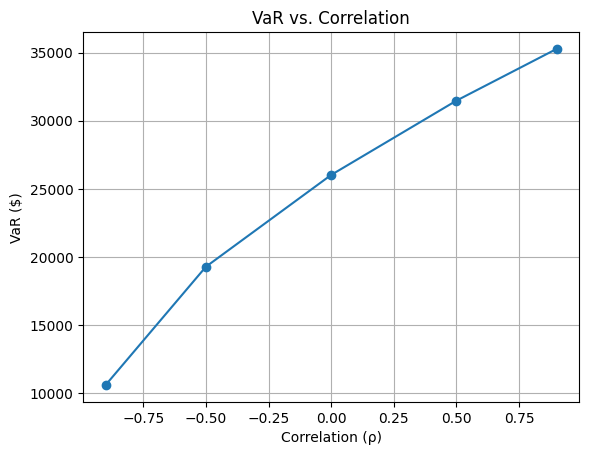

In [10]:
import matplotlib.pyplot as plt

plt.plot(rho_values, var_values, marker="o")
plt.xlabel("Correlation (ρ)")
plt.ylabel("VaR ($)")
plt.title("VaR vs. Correlation")
plt.grid()
plt.show()
